In [194]:
import pandas as pd
import numpy as np
import datetime as dt

In [195]:
#Uniform dictionary of country names and corresponding ISOs
iso_df = pd.read_csv('../../data/raw/iso_3digit_alpha_country_codes.csv', low_memory=False)
rename_dict = iso_df.set_index('Definition').to_dict()['Code_Value']

In [196]:
#Import list of airsavvi countries
airsavvi = pd.read_csv('../../data/tidy/airsavvi_list.csv')
airsavvi['iso'] = airsavvi['country'].apply(lambda x: rename_dict.get(x))

#Convert airsavvi list to dict (country:iso). Useful when checking for consistency.
airsavvi_dict = {}
for x in range(len(airsavvi)):
    currentid = airsavvi.iloc[x,0]
    currentvalue = airsavvi.iloc[x,1]
    airsavvi_dict.setdefault(currentid, [])
    airsavvi_dict[currentid].append(currentvalue)

#Check for missing ISOs
missingKeys = [key  for (key, value) in airsavvi_dict.items() if value == [None]]    
    
#Mismatch between 3 digit ISO country names and Airsavvi list of countries    
airsavvi_dict['Czech Republic'] = ['CZE']
airsavvi_dict['Republic of Korea'] = ['KOR']
airsavvi_dict['Russia'] = ['RUS']
airsavvi_dict['Serbia'] = ['SRB']
airsavvi_dict['Taiwan'] = ['TWN']

airsavvi_dict

{'Albania': ['ALB'],
 'Argentina': ['ARG'],
 'Australia': ['AUS'],
 'Austria': ['AUT'],
 'Belgium': ['BEL'],
 'Brazil': ['BRA'],
 'Bulgaria': ['BGR'],
 'Cambodia': ['KHM'],
 'Canada': ['CAN'],
 'Chile': ['CHL'],
 'Colombia': ['COL'],
 'Croatia': ['HRV'],
 'Czech Republic': ['CZE'],
 'Denmark': ['DNK'],
 'Egypt': ['EGY'],
 'Estonia': ['EST'],
 'Finland': ['FIN'],
 'France': ['FRA'],
 'Germany': ['DEU'],
 'Greece': ['GRC'],
 'Hong Kong': ['HKG'],
 'Hungary': ['HUN'],
 'Iceland': ['ISL'],
 'India': ['IND'],
 'Indonesia': ['IDN'],
 'Ireland': ['IRL'],
 'Israel': ['ISR'],
 'Italy': ['ITA'],
 'Japan': ['JPN'],
 'Latvia': ['LVA'],
 'Lithuania': ['LTU'],
 'Luxembourg': ['LUX'],
 'Macao': ['MAC'],
 'Malaysia': ['MYS'],
 'Mexico': ['MEX'],
 'Morocco': ['MAR'],
 'Netherlands': ['NLD'],
 'New Zealand': ['NZL'],
 'Norway': ['NOR'],
 'Philippines': ['PHL'],
 'Poland': ['POL'],
 'Portugal': ['PRT'],
 'Republic of Korea': ['KOR'],
 'Romania': ['ROU'],
 'Russia': ['RUS'],
 'Saudi Arabia': ['SAU'],
 'Se

In [197]:
#Mismatch between 3 digit ISO country names and Airsavvi list of countries
airsavvi.loc[airsavvi.country == 'Russia', 'iso'] = "RUS"
airsavvi.loc[airsavvi.country == 'Serbia', 'iso'] = "SRB"
airsavvi.loc[airsavvi.country == 'Taiwan', 'iso'] = "TWN"
airsavvi.loc[airsavvi.country == 'Republic of Korea', 'iso'] = "KOR"
airsavvi.loc[airsavvi.country == 'Czech Republic', 'iso'] = "CZE"

In [198]:
#Retain vars of interest (economic indicators)
deterministic = pd.read_csv('../../data/raw/deterministic_wdi.csv', low_memory=False)

deterministic['iso'] = deterministic['country'].apply(lambda x: rename_dict.get(x))

#Use ifs if iso is empty
iso_na = pd.isna(deterministic['iso'])
if(iso_na.any()):
    deterministic['iso'] = deterministic['ifs']

deterministic = deterministic[['iso', 'year','pop_WDI_PW', 'gdp_WDI_PW', 'gdppc_WDI_PW', 'growth_WDI_PW', 'pop_WDI', 'pop_den_WDI',
                              'pop_urb_WDI', 'pop0_14_WDI', 'workingpop_WDI']]    

deterministic = deterministic.loc[deterministic['iso'].isin(airsavvi['iso'])]

deterministic.set_index('iso')
deterministic.head()

,iso,year,pop_WDI_PW,gdp_WDI_PW,gdppc_WDI_PW,growth_WDI_PW,pop_WDI,pop_den_WDI,pop_urb_WDI,pop0_14_WDI,workingpop_WDI
0,USA,2015,321418820.0,1.659740e+13,51638.06520,2.596148,321418820.0,35.137647,81.61,18.950345,66.263585
1,CAN,2015,35848610.0,1.796300e+12,50108.06500,0.941676,35848610.0,3.942219,81.82,15.972058,67.892163
15,MEX,2015,127017224.0,1.208010e+12,9510.59625,2.464956,127017224.0,65.339759,79.24,27.605436,65.927575
23,COL,2015,48228704.0,3.592010e+11,7447.87725,3.083286,48228704.0,43.468863,76.43,24.286773,68.674221
29,BRA,2015,207847528.0,2.330360e+12,11211.89110,-3.769253,207847528.0,24.867677,85.68,23.027646,69.127679


In [199]:
#Print output in tidy
deterministic.to_csv('../../data/tidy/deterministic.csv')

In [200]:
#JHU tracking new COVID cases
cases = pd.read_csv('../../data/raw/confirmed_cases_global.csv', low_memory=False)
cases['iso'] = cases["Country/Region"].apply(lambda x: rename_dict.get(x))

#Aggregating new covid cases based on subregional breakdown
total_cases = cases.groupby(by = ['iso']).sum()

#Subset of countries with airsavvi flight data from Feb 15 to Aug 31
total_cases = total_cases.loc[total_cases.index.isin(airsavvi['iso'])]
total_cases = total_cases.loc[:, '2/15/2020':'8/31/2020']

total_cases.head()

,2/15/2020,2/16/2020,2/17/2020,2/18/2020,2/19/2020,2/20/2020,2/21/2020,2/22/2020,2/23/2020,2/24/2020,...,8/22/2020,8/23/2020,8/24/2020,8/25/2020,8/26/2020,8/27/2020,8/28/2020,8/29/2020,8/30/2020,8/31/2020
iso,,,,,,,,,,,,,,,,,,,,,
ALB,0,0,0,0,0,0,0,0,0,0,...,8275,8427,8605,8759,8927,9083,9195,9279,9380,9513
ARE,8,9,9,9,9,9,9,13,13,13,...,66617,67007,67282,67621,68020,68511,68901,69328,69690,70231
ARG,0,0,0,0,0,0,0,0,0,0,...,336802,342154,350867,359638,370188,380292,392009,401239,408426,417735
AUS,15,15,15,15,15,15,15,15,15,15,...,24811,24915,25053,25204,25322,25448,25547,25670,25746,25819
AUT,0,0,0,0,0,0,0,0,0,0,...,25062,25253,25495,25706,26033,26361,26590,26985,27166,27438


In [201]:
#JHU tracking COVID deaths
deaths = pd.read_csv('../../data/raw/covid_deaths_global.csv', low_memory=False)
deaths['iso'] = deaths['Country/Region'].apply(lambda x: rename_dict.get(x))

#Aggregating covid deaths based on subregional breakdown
total_deaths = deaths.groupby(by = ['iso']).sum()

#Subset of countries with airsavvi flight data from Feb 15 to Aug 31
total_deaths = total_deaths.loc[total_deaths.index.isin(airsavvi['iso'])]
total_deaths = total_deaths.loc[:, '2/15/2020':'8/31/2020']

total_deaths.head()

,2/15/2020,2/16/2020,2/17/2020,2/18/2020,2/19/2020,2/20/2020,2/21/2020,2/22/2020,2/23/2020,2/24/2020,...,8/22/2020,8/23/2020,8/24/2020,8/25/2020,8/26/2020,8/27/2020,8/28/2020,8/29/2020,8/30/2020,8/31/2020
iso,,,,,,,,,,,,,,,,,,,,,
ALB,0,0,0,0,0,0,0,0,0,0,...,245,250,254,259,263,266,271,275,280,284
ARE,0,0,0,0,0,0,0,0,0,0,...,372,375,376,377,378,378,379,379,382,384
ARG,0,0,0,0,0,0,0,0,0,0,...,6848,6985,7366,7563,7839,8050,8271,8353,8457,8660
AUS,0,0,0,0,0,0,0,0,0,0,...,502,517,525,549,572,583,600,611,652,657
AUT,0,0,0,0,0,0,0,0,0,0,...,732,732,733,733,733,733,733,733,733,733


In [202]:
#Concatenate cases and deaths
frames = [total_cases, total_deaths]
result = pd.concat(frames, keys=['cases', 'deaths'])

#Print output in tidy
result.to_csv("../../data/tidy/cases_deaths_concat.csv")

In [203]:
#Google activity
activity = pd.read_csv('../../data/raw/google_activity.csv', low_memory=False)

activity = activity.rename(columns={"country_region": "country",
                        "country_region_code": "iso", #multi-index label consistency across different sources
                        "retail_and_recreation_percent_change_from_baseline": "retail", 
                        "grocery_and_pharmacy_percent_change_from_baseline": "grocery",
                        "parks_percent_change_from_baseline": "parks",
                        "transit_stations_percent_change_from_baseline": "transit",
                        "workplaces_percent_change_from_baseline": "workplaces",
                        "residential_percent_change_from_baseline": "residential"})

activity['iso'] = activity["country"].apply(lambda x: rename_dict.get(x))

activity = activity[['iso', 'date','retail', 'grocery', 'parks', 'transit', 'workplaces', 'residential']]

#Subset of countries with airsavvi flight data
activity = activity.loc[activity['iso'].isin(airsavvi['iso'])]

#Aggregating baselines by activity type
unpivoted = pd.melt(activity, id_vars=['iso', 'date'], value_vars = ['retail', 'grocery', 'parks', 'transit', 'workplaces', 'residential'], 
        var_name="activity", 
        value_name="percent_change")

unpivoted = unpivoted.pivot_table(index=['iso','activity'],columns='date',values='percent_change')

#Limit dataset to Feb 15-Aug 31
unpivoted = unpivoted.loc[:, '2020-02-15':'2020-08-31']

unpivoted.head()

date             2020-02-15  2020-02-16  2020-02-17  2020-02-18  2020-02-19  \
iso activity                                                                  
ARE grocery             4.0         4.0         1.0         1.0         0.0   
    parks               5.0         4.0         5.0         5.0         4.0   
    residential         1.0         1.0         1.0         1.0         1.0   
    retail              0.0         1.0        -1.0        -2.0        -2.0   
    transit             0.0         1.0         1.0         0.0        -1.0   

date             2020-02-20  2020-02-21  2020-02-22  2020-02-23  2020-02-24  \
iso activity                                                                  
ARE grocery             1.0         2.0         2.0         3.0         0.0   
    parks               6.0         6.0         4.0         3.0         5.0   
    residential         1.0         1.0         1.0         1.0         1.0   
    retail             -2.0        -3.0        -2.0        -1.0        -3.0   
    transit             1.0         0.0        -2.0        -1.0        -1.0   

date             ...  2020-08-22  2020-08-23  2020-08-24  2020-08-25  \
iso activity     ...                                                   
ARE grocery      ...        -9.0         1.0       -10.0        -8.0   
    parks        ...       -43.0       -37.0       -42.0       -41.0   
    residential  ...         8.0        22.0        10.0        10.0   
    retail       ...       -23.0       -19.0       -25.0       -24.0   
    transit      ...       -44.0       -53.0       -42.0       -41.0   

date             2020-08-26  2020-08-27  2020-08-28  2020-08-29  2020-08-30  \
iso activity                                                                  
ARE grocery            -7.0        -5.0       -11.0        -5.0         2.0   
    parks             -41.0       -42.0       -55.0       -46.0       -38.0   
    residential        10.0        11.0        10.0         8.0         9.0   
    retail            -23.0       -22.0       -30.0       -23.0       -18.0   
    transit           -41.0       -41.0       -47.0       -42.0       -40.0   

date             2020-08-31  
iso activity                 
ARE grocery            -3.0  
    parks             -40.0  
    residential        10.0  
    retail            -21.0  
    transit           -41.0  

[5 rows x 199 columns]

In [204]:
#Print output in tidy
unpivoted.to_csv("../../data/tidy/google_activity.csv")

In [102]:
#Merge aaggregated data sets - In Progress
deterministic_df = pd.read_csv('../../data/raw/deterministic_wdi_iso.csv', low_memory=False)
mobility_activity_df = pd.read_csv('../../data/tidy/cases_mobility_activity.csv', low_memory=False)
measures_df = pd.read_csv('../../data/raw/govt_measures.csv', low_memory=False)

rename_dict = iso_df.set_index('Definition').to_dict()['Code_Value']
mobility_activity_df["iso"] = mobility_activity_df["region"].apply(lambda x: rename_dict.get(x))
deterministic_df["iso"] = deterministic_df["country"].apply(lambda x: rename_dict.get(x))

unique_region = set(mobility_activity_df.iso.unique().tolist())
deterministic_countries = set(deterministic_df['ifs'].values.tolist())


def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

mobility_deterministic = pd.merge(mobility_activity_df, deterministic_df, how='left', left_on='iso', right_on='ifs')
mobility_deterministic_measures = pd.merge(mobility_deterministic, measures_df, left_on='ifs', right_on='ISO')

mobility_activity_df.tail()

,geo_type,region,iso,transportation_type,alternative_name,sub-region,country,1/13/2020,1/14/2020,1/15/2020,...,7/5/2020,7/6/2020,7/7/2020,7/8/2020,7/9/2020,7/10/2020,7/11/2020,7/12/2020,7/13/2020,7/14/2020
589,country/region,Vietnam,VNM,grocery_and_pharmacy_percent_change_from_baseline,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,8.0,10.0,3.0,5.0,8.0,13.0,10.0,NaN,NaN
590,country/region,Vietnam,VNM,parks_percent_change_from_baseline,NaN,NaN,NaN,NaN,NaN,NaN,...,-14.0,-13.0,-15.0,-18.0,-17.0,-14.0,-12.0,-9.0,NaN,NaN
591,country/region,Vietnam,VNM,transit_stations_percent_change_from_baseline,NaN,NaN,NaN,NaN,NaN,NaN,...,-4.0,-4.0,-1.0,-6.0,-5.0,0.0,2.0,1.0,NaN,NaN
592,country/region,Vietnam,VNM,workplaces_percent_change_from_baseline,NaN,NaN,NaN,NaN,NaN,NaN,...,-6.0,12.0,14.0,13.0,10.0,-1.0,-2.0,-7.0,NaN,NaN
593,country/region,Vietnam,VNM,residential_percent_change_from_baseline,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,4.0,3.0,2.0,0.0,4.0,5.0,4.0,NaN,NaN


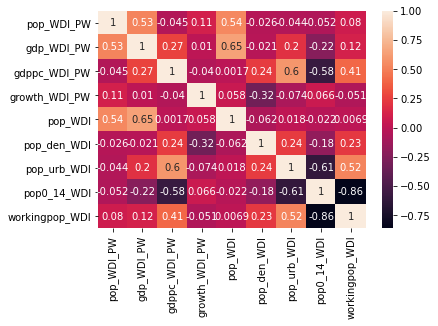

In [99]:
#Correlation matrix - deterministic vars
import seaborn as sn
import matplotlib.pyplot as plt

len(unique_region)
cor_matrix = deterministic_df.iloc[:,7:].corr()

sn.heatmap(cor_matrix, annot=True)
plt.show()